In [ ]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
# Discard the output of this cell.


# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

In [ ]:
constant_seed=27
np.random.seed(constant_seed)
tf.random.set_seed(constant_seed)
random.seed(constant_seed)


In [ ]:
DIR="UCF50"
video_names=[]
class_names=os.listdir(DIR)
for i in range(len(class_names)):
  for j in os.listdir(f"{DIR}/{class_names[i]}"):
    video_names.append(j)
    break;

len(video_names)


50

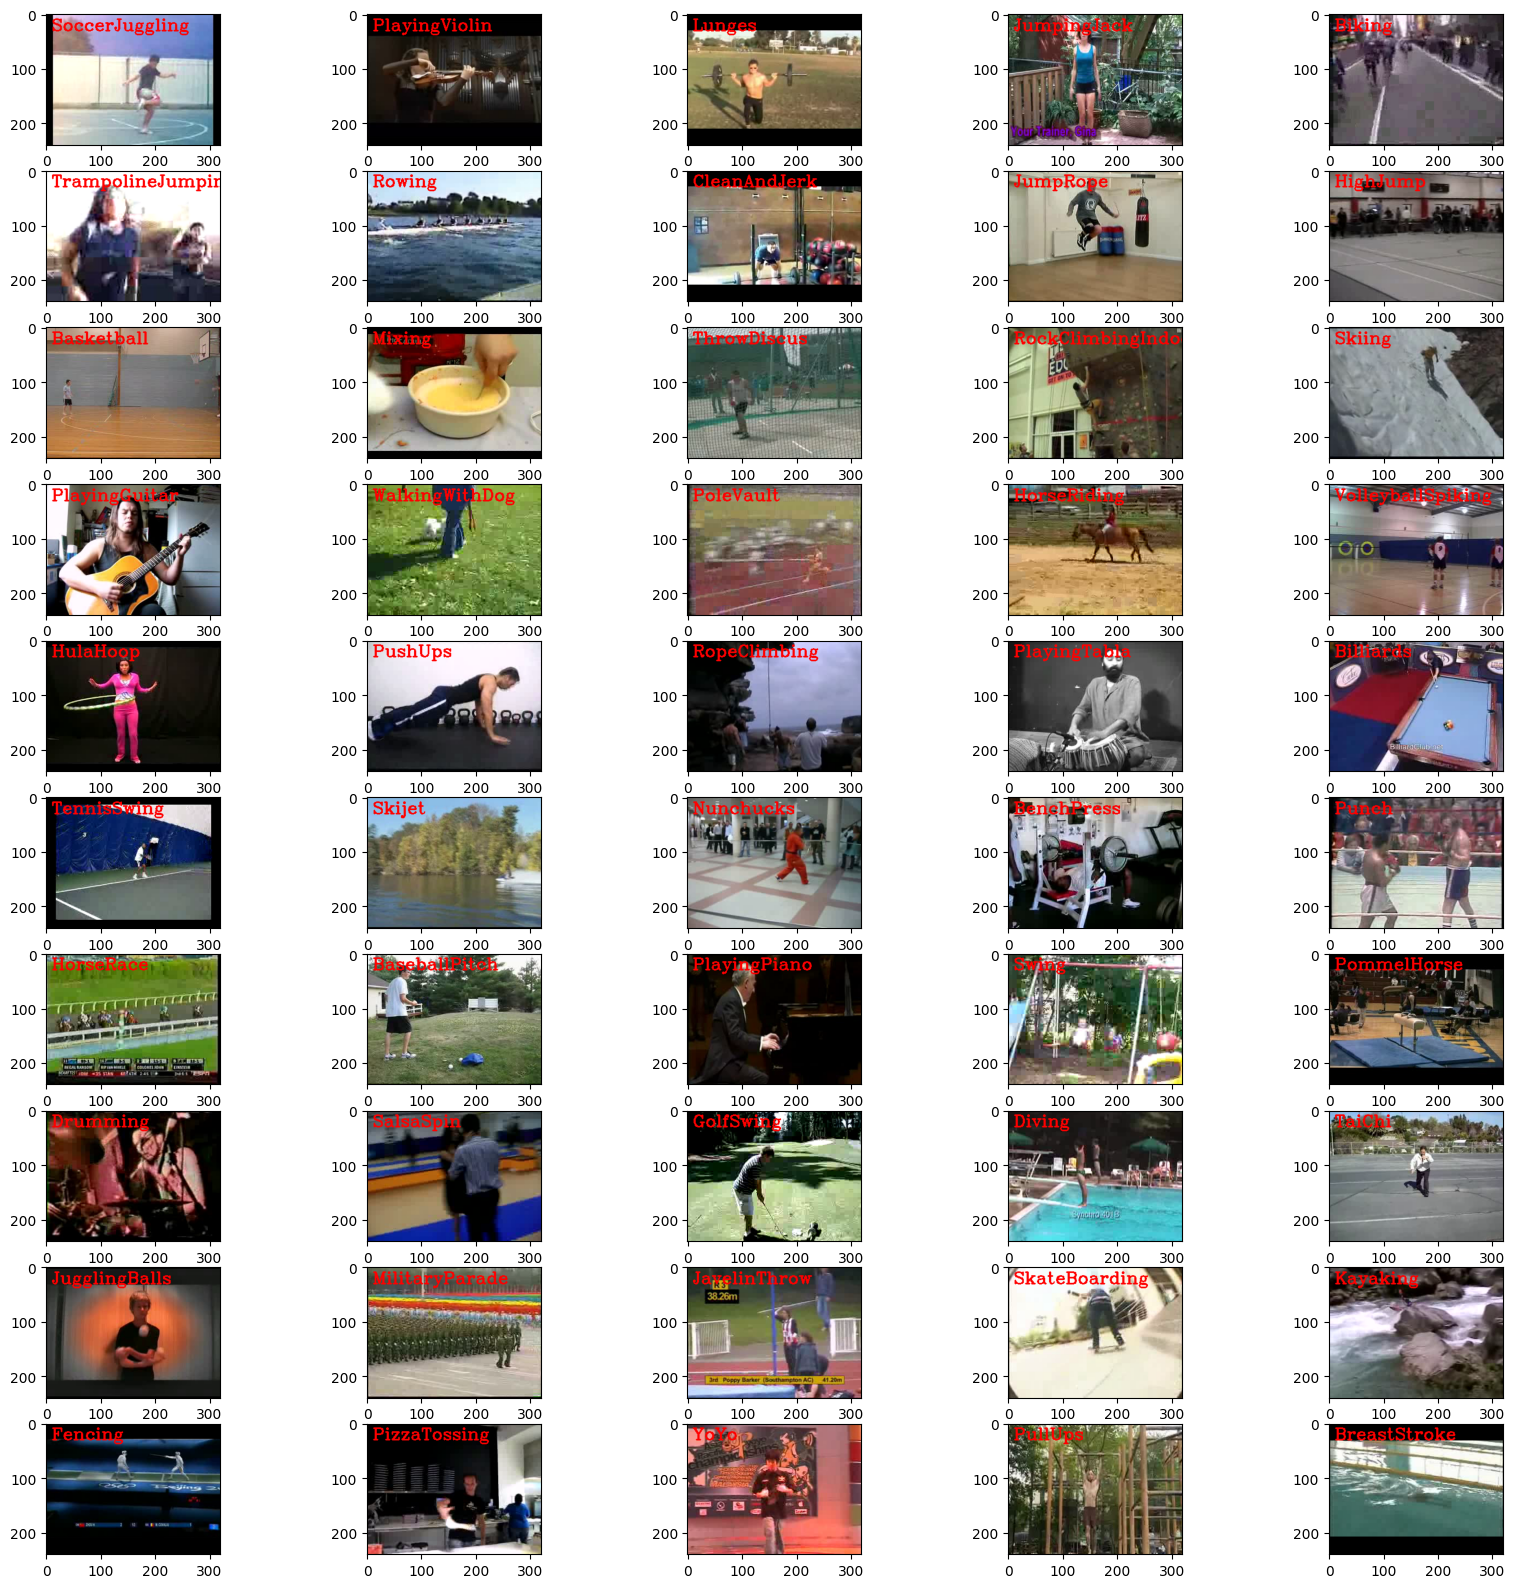

In [ ]:
plt.figure(figsize=(20,20))
for i in range(len(video_names)):
  single_frame_dir=os.path.join(DIR,class_names[i],video_names[i])
  video_reader=cv2.VideoCapture(single_frame_dir)
  _, bgr_frame=video_reader.read()
  video_reader.release()
  rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
  rgb_frame=cv2.putText(rgb_frame,class_names[i],(10,30),cv2.FONT_HERSHEY_COMPLEX,1,(255,0,0),2)
  plt.subplot(10,5,i+1)
  plt.imshow(rgb_frame)

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
FRAMES_NEEDED_PER_VIDEO=25
classes_to_be_used=["HorseRace","BenchPress","PullUps","PushUps","HorseRiding","HighJump","Swing"]

In [ ]:
def frame_extraction(full_path_video,class_path):
  video_capture=cv2.VideoCapture(full_path_video)
  frame_list=[]
  frame_count=int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_window=max(int(frame_count/FRAMES_NEEDED_PER_VIDEO),1)
  for frame_counter in range(FRAMES_NEEDED_PER_VIDEO):
    video_capture.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_window)
    success,framess=video_capture.read()
    if not success:
            break
    resized_frame = cv2.resize(framess, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frame_list.append(normalized_frame)
  video_reader.release()
  return frame_list


In [ ]:
def create_dataframe():
  features=[]
  labels=[]
  video_full_path=[]

  for index, element in enumerate(classes_to_be_used):
    class_path=os.path.join(DIR,element)
    videos_in_class=os.listdir(class_path)
    print(f"extracting {element}")

    for ind, single_video in enumerate(videos_in_class):

      frames_in_video=frame_extraction(os.path.join(class_path,single_video),class_path)

      if len(frames_in_video)==FRAMES_NEEDED_PER_VIDEO:
        features.append(frames_in_video)
        labels.append(index)
        video_full_path.append(os.path.join(class_path,single_video))

  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_full_path


In [ ]:
features,labels,video_full_path=create_dataframe()

extracting HorseRace
extracting BenchPress
extracting PullUps
extracting PushUps
extracting HorseRiding
extracting HighJump


KeyboardInterrupt: ignored

In [ ]:
features.shape

In [ ]:
labels.shape

In [ ]:
len(video_full_path)

so everything seems to work. there are 1361 videos, 20 frames pervideo and length and height is 64,64 and there are 3 channels that is RGB.

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = constant_seed)

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (FRAMES_NEEDED_PER_VIDEO, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(classes_to_be_used), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
!pip install pytube3

In [ ]:
!pip install pytube@git+https://github.com/priyankaj1311/pytube.git@master_copy


In [ ]:
from pytube import YouTube

video_url = 'https://youtu.be/6ahjasEHsTQ'

yt = YouTube(video_url)

video_title = yt.title
print(f"Video Title: {video_title}")

output_dir = '/content/test_videos'

video_stream = yt.streams.get_highest_resolution()

video_stream.download(output_path=output_dir)

print("Video downloaded successfully!")


HTTPError: ignored

In [ ]:
classes_to_be_used=["HorseRace","BenchPress","PullUps","PushUps","HorseRiding","HighJump","Swing"]

In [ ]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)


input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

NameError: ignored

In [ ]:
def predict_on_video(video_file_path, output_file_path, FRAMES_NEEDED_PER_VIDEO):


    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = FRAMES_NEEDED_PER_VIDEO)

    predicted_class_name = ''

    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == FRAMES_NEEDED_PER_VIDEO:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = classes_to_be_used[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'/content/test_videos/{video_title}_output.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, FRAMES_NEEDED_PER_VIDEO)


In [ ]:
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None), ).ipython_display(maxduration=80)